# Introduction

Movie recommendation systems are widely used in many online platforms like Netflix, Amazon Prime, and Hulu. These systems are designed to provide personalized movie recommendations to users based on their viewing history, ratings, and preferences.

In this notebook, we will be building a movie recommender system using the MovieLens dataset. The dataset contains 25 million ratings from 270,000 users for over 62,000 movies. Our goal is to build a system that can predict how a user will rate a movie that they have not seen yet, and recommend the movies with the highest predicted ratings.

We will be using maximum likelihood estimation (MLE) to build our recommendation system. MLE is a commonly used statistical method that estimates the parameters of a statistical model by maximizing the likelihood of the observed data. In our case, the model will be trained on the MovieLens dataset and the parameters will be the user preferences and the movie features.

We will start by importing and preprocessing the data, then we will explore the data and perform some data analysis. This will be done on both the `ml-latest-small `dataset as well as the `ml-25m` dataset. After that, we will implement the MLE algorithm to train our model and make predictions. Finally, we will evaluate the performance of our model and provide recommendations based on the predictions.

Let's get started!

# Exploratory Data Analysis

In [1]:
# import some basic EDA libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import powerlaw
%matplotlib inline

In [18]:
# set the file path to read in the data
filepath = '../data/ml-latest-small/'

In [28]:
movies = pd.read_csv(filepath + 'movies.csv')
ratings = pd.read_csv(filepath + 'ratings.csv')
tags = pd.read_csv(filepath + 'tags.csv')

In [21]:
# check the data
movies.head()


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [22]:
# get some basic info about the data
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [30]:
ratings.head()

,userId,movieId,rating,timestamp,datetime
0,1,1,4.0,964982703,2000-07-30 18:45:03
1,1,3,4.0,964981247,2000-07-30 18:20:47
2,1,6,4.0,964982224,2000-07-30 18:37:04
3,1,47,5.0,964983815,2000-07-30 19:03:35
4,1,50,5.0,964982931,2000-07-30 18:48:51


In [31]:
tags.head()

,userId,movieId,tag,timestamp,datetime
0,2,60756,funny,1445714994,2015-10-24 19:29:54
1,2,60756,Highly quotable,1445714996,2015-10-24 19:29:56
2,2,60756,will ferrell,1445714992,2015-10-24 19:29:52
3,2,89774,Boxing story,1445715207,2015-10-24 19:33:27
4,2,89774,MMA,1445715200,2015-10-24 19:33:20


In [29]:
# out of curiousity let's covert the timestamp to a datetime object
tags['datetime'] = pd.to_datetime(tags['timestamp'], unit='s')
ratings['datetime'] = pd.to_datetime(ratings['timestamp'], unit='s')

In [32]:
# count the number of unique users and movies
n_users = ratings.userId.unique().shape[0]
n_movies = ratings.movieId.unique().shape[0]

print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_movies))

Number of users = 610 | Number of movies = 9724


In [38]:
# check how many movies are in the ratings dataframe but not in the movies dataframe
movies_not_in_ratings = movies[~movies['movieId'].isin(ratings['movieId'])]
print('Number of movies in movies but not in ratings: ' + str(movies_not_in_ratings.shape[0]))
print('So there are ' + str(movies_not_in_ratings.shape[0]) + ' movies that have not been rated by any user.')

Number of movies in movies but not in ratings: 18
So there are 18 movies that have not been rated by any user.


In [39]:
# create a sparse matrix of the ratings and movies that have been rated
ratings_matrix = ratings.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
ratings_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Calculating best minimal value for power law fit


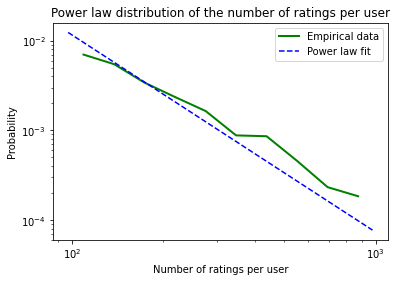

In [71]:
# plot the power law distribution of the number of ratings per user
ratings_per_user = ratings.groupby('userId').count()['rating']
ratings_per_user = ratings_per_user[ratings_per_user < 1000]
fit = powerlaw.Fit(ratings_per_user)
fit.plot_pdf(color='g', linewidth=2)
fit.power_law.plot_pdf(color='b', linestyle='--', ax=plt.gca())
plt.xlabel('Number of ratings per user')
plt.ylabel('Probability')
plt.title('Power law distribution of the number of ratings per user')
plt.legend(['Empirical data', 'Power law fit'])
plt.show()

In [59]:
# check if there are movies rated 1.5, 2.5, 3.5, 4.5
_check_ratings_increments = ratings['rating'].unique()
print(f'The rating increments are: {sorted(_check_ratings_increments)}')

The rating increments are: [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


### Power laws (/Zipf's law) in the data

Based on the power law plot of the rating distribution that we generated earlier, it appears that there is evidence of a power law in the data. A power law is characterized by a straight line on a log-log plot, and the plot we generated does show a linear relationship between the log of the rating values and the log of their corresponding frequency counts.

However, it's important to note that the presence of a power law in a dataset is not always conclusive evidence of a specific underlying mechanism or process. Power laws are often observed in many different types of natural and social phenomena, and it's possible for a dataset to exhibit a power law distribution even if the underlying mechanism is not truly a power law. In addition, the presence of noise or other confounding factors can also affect the accuracy and interpretation of the power law.

To confirm whether the data follows a power law distribution, we perform a goodness-of-fit test, to compare the distribution of the data to a power law distribution.

In [67]:
# perform goodness of fit test
fit.distribution_compare('power_law', 'lognormal')

(-9.620596748805943, 0.006366902960497619)

The output of `fit.distribution_compare('power_law', 'lognormal')` is a tuple with two values: the log-likelihood ratio statistic and the p-value of the test.

In this case, the log-likelihood ratio statistic is -9.62 and the p-value is 0.006.

The log-likelihood ratio statistic is a measure of the relative goodness of fit of the two distributions being compared (in this case, a power law distribution and a log-normal distribution). A negative value of the statistic indicates that the power law distribution fits the data better than the log-normal distribution.

The p-value is a measure of the strength of evidence against the null hypothesis, which is that the power law distribution and the log-normal distribution fit the data equally well. A p-value less than 0.05 (or some other pre-specified significance level) indicates that there is strong evidence against the null hypothesis and that the power law distribution fits the data significantly better than the log-normal distribution. (The null hypothesis is that the log-normal distribution is a better fit to the data).

In summary, the output (-9.62, 0.006) suggests that the power law distribution is a significantly better fit to the data than the log-normal distribution, based on the log-likelihood ratio test at a significance level of 0.05.

### Scale free behavior in the data

The presence of the power law in the rating distribution would suggest that the distribution of ratings across movies follows a scale-free pattern. In other words, a few movies would receive a large number of ratings, while the majority of movies would receive relatively few ratings.

Similarly, if a power law distribution is observed in the user activity data, it would suggest that the distribution of user ratings follows a scale-free pattern. This means that a few users would rate a large number of movies, while the majority of users would rate relatively few movies.

The observation of a power law distribution in the ratings data or user activity data could have implications for the design of recommender systems based on this dataset. Specifically, it suggests that a few movies and users have a disproportionately large influence on the overall ratings distribution, and therefore their ratings should be given greater or smaller weight in any recommendation algorithm depending on what we are trying to achieve.

For now, let us continue with our analysis of the data.

<AxesSubplot:xlabel='rating', ylabel='count'>

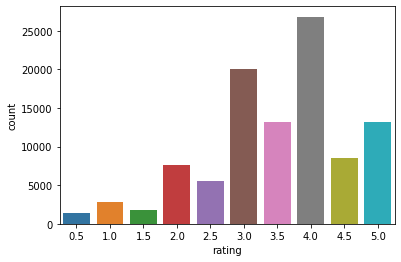

In [72]:
# let's see the distribution of ratings
sns.countplot(x='rating', data=ratings)

In [121]:
# count the number of ratings
ratings['rating'].value_counts().sort_index()

0.5     1370
1.0     2811
1.5     1791
2.0     7551
2.5     5550
3.0    20047
3.5    13136
4.0    26818
4.5     8551
5.0    13211
Name: rating, dtype: int64

In [73]:
# let's see how many ratings each user has given
ratings_per_user = ratings.groupby('userId').count()['rating']
ratings_per_user.head()

userId
1    232
2     29
3     39
4    216
5     44
Name: rating, dtype: int64

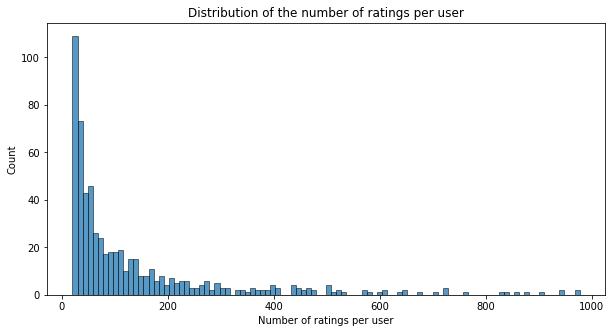

In [76]:
# plot the distribution of the number of ratings per user
# create a dataframe with the number of ratings per user
ratings_per_user = ratings.groupby('userId').count()['rating']
ratings_per_user = ratings_per_user[ratings_per_user < 1000]
plt.figure(figsize=(10, 5))
sns.histplot(ratings_per_user, kde=False, bins=100)
plt.xlabel('Number of ratings per user')
plt.ylabel('Count')
plt.title('Distribution of the number of ratings per user')
plt.show()

In [78]:
# let's see how many ratings each movie has received
ratings_per_movie = ratings.groupby('movieId').count()['rating']
ratings_per_movie.head()

movieId
1    215
2    110
3     52
4      7
5     49
Name: rating, dtype: int64

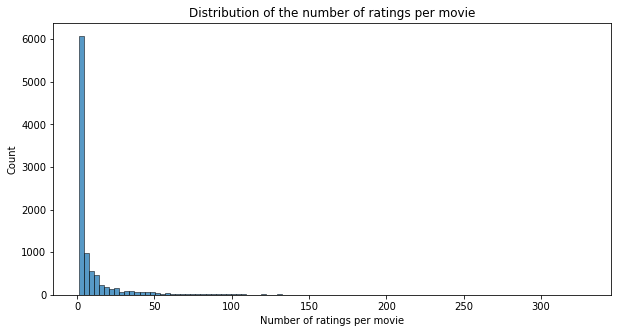

In [79]:
# plot the distribution of the number of ratings per movie
# create a dataframe with the number of ratings per movie
ratings_per_movie = ratings.groupby('movieId').count()['rating']
ratings_per_movie = ratings_per_movie[ratings_per_movie < 1000]
plt.figure(figsize=(10, 5))
sns.histplot(ratings_per_movie, kde=False, bins=100)
plt.xlabel('Number of ratings per movie')
plt.ylabel('Count')
plt.title('Distribution of the number of ratings per movie')
plt.show()

<AxesSubplot:ylabel='None'>

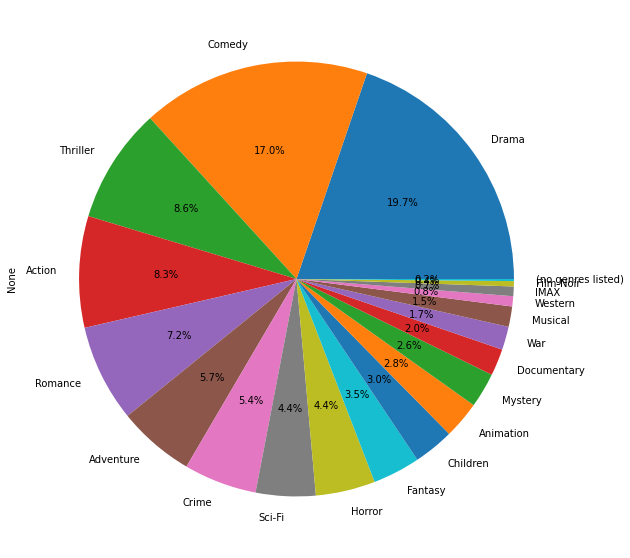

In [91]:
# plot a pie chart of the genres (even though pie charts are not the best way convey information)
movies['genres'].str.split('|').apply(pd.Series).stack().value_counts().plot(kind='pie', figsize=(10,10), autopct='%1.1f%%')

<AxesSubplot:title={'center':'Number of movies in each genre'}, xlabel='Genre', ylabel='Number of movies'>

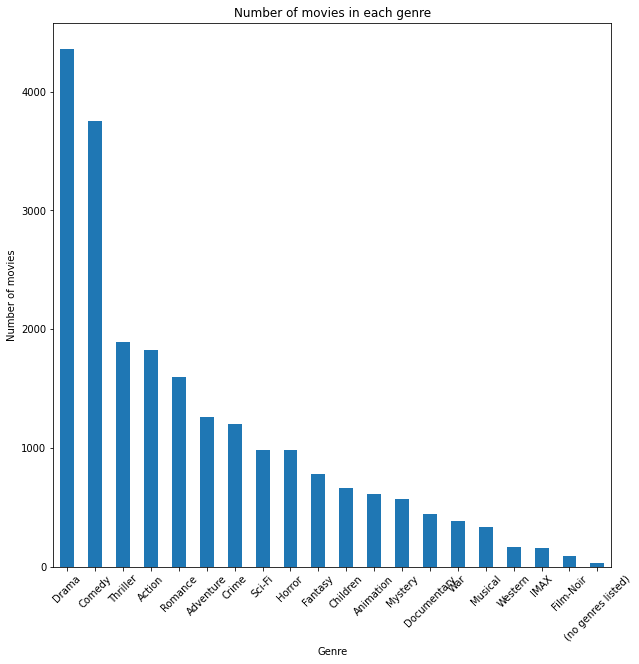

In [103]:
# plot the bar chart of the number of movies in each genre 
# bar charts are much better than pie charts. Propotionally, they are much easier to interpret
movies['genres'].str.split('|').apply(pd.Series).stack().value_counts().plot(kind='bar', figsize=(10,10), rot=45, title='Number of movies in each genre', xlabel='Genre', ylabel='Number of movies')


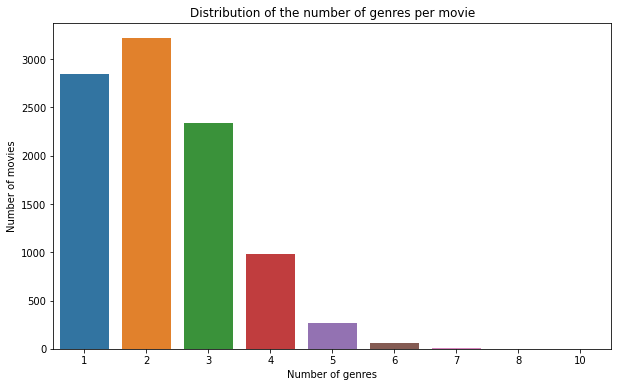

In [106]:
# plot the distribution of the number of genres per movie
movies['num_genres'] = movies['genres'].str.split('|').apply(len)
movies['num_genres'].value_counts()

# plot the distribution of the number of genres per movie
plt.figure(figsize=(10, 6))
sns.countplot(x='num_genres', data=movies)
plt.xlabel('Number of genres')
plt.ylabel('Number of movies')
plt.title('Distribution of the number of genres per movie')
plt.show()

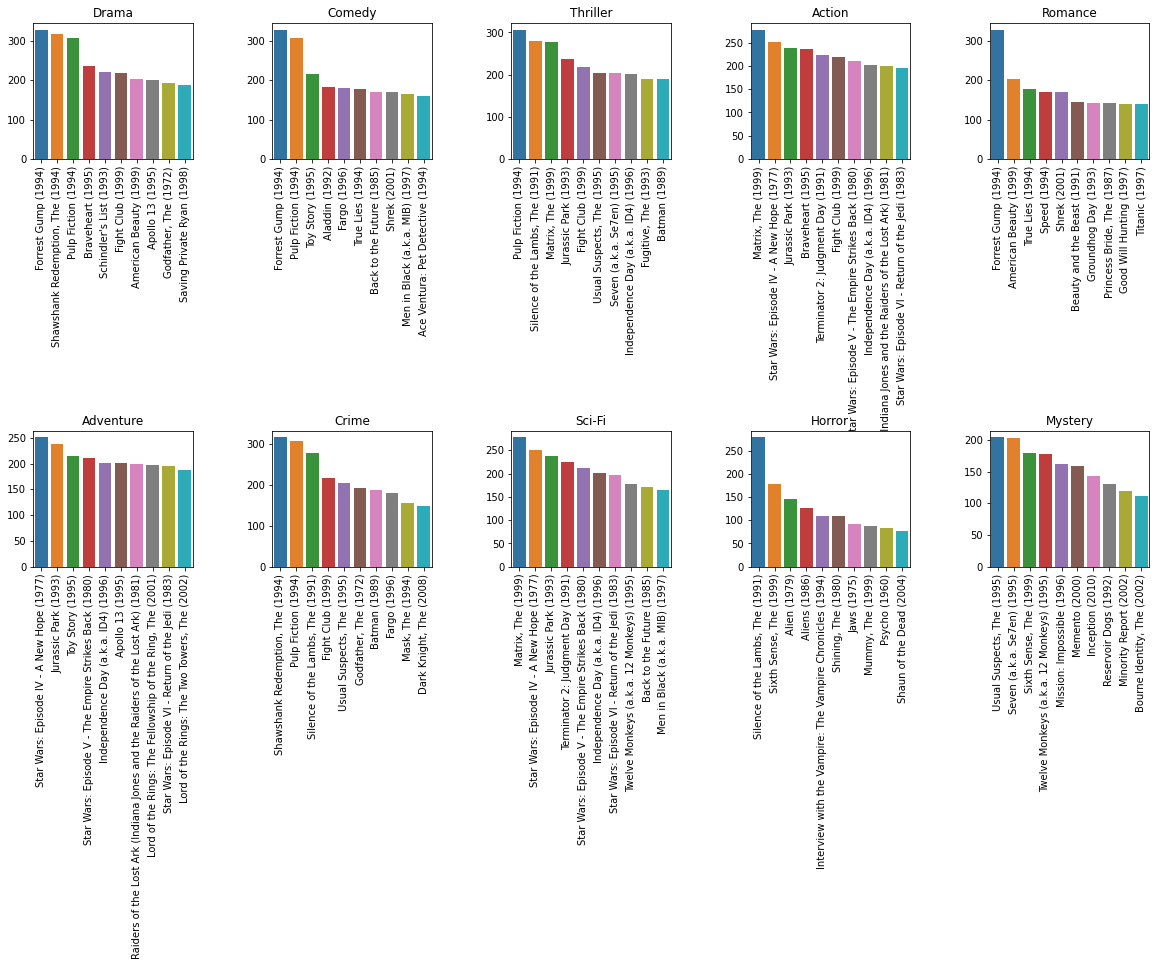

In [107]:
# plot the distribution of top 10 movies in terms of number of ratings received for the top 10 genres
top_genres = ['Drama', 'Comedy', 'Thriller', 'Action', 'Romance', 'Adventure', 'Crime', 'Sci-Fi', 'Horror', 'Mystery']
top_movies = movies[movies['genres'].str.contains('|'.join(top_genres))]
top_movies = top_movies.merge(ratings_per_movie, on='movieId', how='inner')
top_movies = top_movies.sort_values('rating', ascending=False).head(10)
top_movies

# plot the distribution of top 10 movies in terms of number of ratings received for the top 10 genres
# create a subplot with 2 rows and 5 columns
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
# plot the top 10 movies in terms of number of ratings received for each genre in each subplot
for i, genre in enumerate(top_genres):
    top_movies = movies[movies['genres'].str.contains(genre)]
    top_movies = top_movies.merge(ratings_per_movie, on='movieId', how='inner')
    top_movies = top_movies.sort_values('rating', ascending=False).head(10)
    sns.barplot(x='title', y='rating', data=top_movies, ax=axes[i//5, i%5])
    axes[i//5, i%5].set_title(genre)
    axes[i//5, i%5].set_xlabel('')
    axes[i//5, i%5].set_ylabel('')
    axes[i//5, i%5].tick_params(axis='x', labelrotation=90)
# adjust the subplot layout to favor space between subplots
plt.subplots_adjust(wspace=0.5, hspace=2)
plt.show()

### Some light data cleaning

In [108]:
# clean the data
# remove movies with less than 10 ratings
min_movie_ratings = 10
filter_movies = ratings_per_movie > min_movie_ratings
filter_movies = filter_movies[filter_movies].index.tolist()

# remove users who have given less than 10 ratings
min_user_ratings = 10
filter_users = ratings_per_user > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

# filter data
ratings_new = ratings[(ratings['movieId'].isin(filter_movies)) & (ratings['userId'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(ratings.shape))
print('The new data frame shape:\t{}'.format(ratings_new.shape))

# create a user-movie matrix
ratings_matrix = ratings_new.pivot(index='userId', columns='movieId', values='rating').fillna(0)
ratings_matrix.head()

# create a sparse matrix
from scipy.sparse import csr_matrix

# create a sparse matrix
ratings_matrix_sparse = csr_matrix(ratings_matrix.values)

The original data frame shape:	(100836, 5)
The new data frame shape:	(68376, 5)


In [110]:
print(ratings_matrix_sparse)

  (0, 0)	4.0
  (0, 2)	4.0
  (0, 4)	4.0
  (0, 34)	5.0
  (0, 36)	5.0
  (0, 43)	3.0
  (0, 52)	5.0
  (0, 56)	4.0
  (0, 68)	5.0
  (0, 71)	5.0
  (0, 77)	5.0
  (0, 100)	5.0
  (0, 103)	3.0
  (0, 108)	5.0
  (0, 112)	4.0
  (0, 124)	5.0
  (0, 141)	3.0
  (0, 149)	3.0
  (0, 156)	5.0
  (0, 164)	4.0
  (0, 169)	4.0
  (0, 172)	5.0
  (0, 175)	4.0
  (0, 205)	4.0
  (0, 210)	5.0
  :	:
  (597, 56)	3.0
  (597, 67)	3.0
  (597, 75)	3.0
  (597, 88)	3.0
  (597, 98)	3.0
  (597, 108)	3.0
  (597, 121)	4.0
  (597, 137)	3.0
  (597, 139)	3.0
  (597, 141)	4.0
  (597, 151)	4.0
  (597, 154)	3.0
  (597, 159)	3.0
  (597, 169)	4.0
  (597, 202)	3.0
  (597, 208)	3.0
  (597, 210)	4.0
  (597, 217)	3.0
  (597, 263)	3.0
  (597, 264)	4.0
  (597, 265)	3.0
  (597, 299)	3.0
  (597, 312)	3.0
  (597, 333)	3.0
  (597, 396)	3.0


In [111]:
# see which movieIds have the highest number of views
ratings_per_movie.sort_values(ascending=False).head(10)

movieId
356     329
318     317
296     307
593     279
2571    278
260     251
480     238
110     237
589     224
527     220
Name: rating, dtype: int64

In [118]:
# The most popular movies
top_movies = movies[movies['movieId'].isin(ratings_per_movie.sort_values(ascending=False).head(10).index)]
top_movies


,movieId,title,genres,num_genres
97,110,Braveheart (1995),Action|Drama|War,3
224,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,3
257,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4
277,318,"Shawshank Redemption, The (1994)",Crime|Drama,2
314,356,Forrest Gump (1994),Comedy|Drama|Romance|War,4
418,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,4
461,527,Schindler's List (1993),Drama|War,2
507,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi,2
510,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,3
1939,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,3


In [119]:
# see which user has the highest number of ratings
ratings_per_user.sort_values(ascending=False).head(10)

userId
182    977
307    975
603    943
298    939
177    904
318    879
232    862
480    836
608    831
600    763
Name: rating, dtype: int64

In [122]:
# merge the ratings and movies data frames
ratings = ratings.merge(movies, on='movieId', how='inner')
ratings.head().sort_values('rating', ascending=False)

,userId,movieId,rating,timestamp,datetime,title,genres,num_genres
2,7,1,4.5,1106635946,2005-01-25 06:52:26,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5
4,17,1,4.5,1305696483,2011-05-18 05:28:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5
0,1,1,4.0,964982703,2000-07-30 18:45:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5
1,5,1,4.0,847434962,1996-11-08 06:36:02,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5
3,15,1,2.5,1510577970,2017-11-13 12:59:30,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5


In [127]:
# print the average rating for each movie rated more than 100 times
ratings.groupby('title').filter(lambda x: len(x) >= 100).groupby('title')['rating'].mean().sort_values(ascending=False).head(30)


title
Shawshank Redemption, The (1994)                                                  4.429022
Godfather, The (1972)                                                             4.289062
Fight Club (1999)                                                                 4.272936
Godfather: Part II, The (1974)                                                    4.259690
Departed, The (2006)                                                              4.252336
Goodfellas (1990)                                                                 4.250000
Casablanca (1942)                                                                 4.240000
Dark Knight, The (2008)                                                           4.238255
Usual Suspects, The (1995)                                                        4.237745
Princess Bride, The (1987)                                                        4.232394
Star Wars: Episode IV - A New Hope (1977)                                         4.

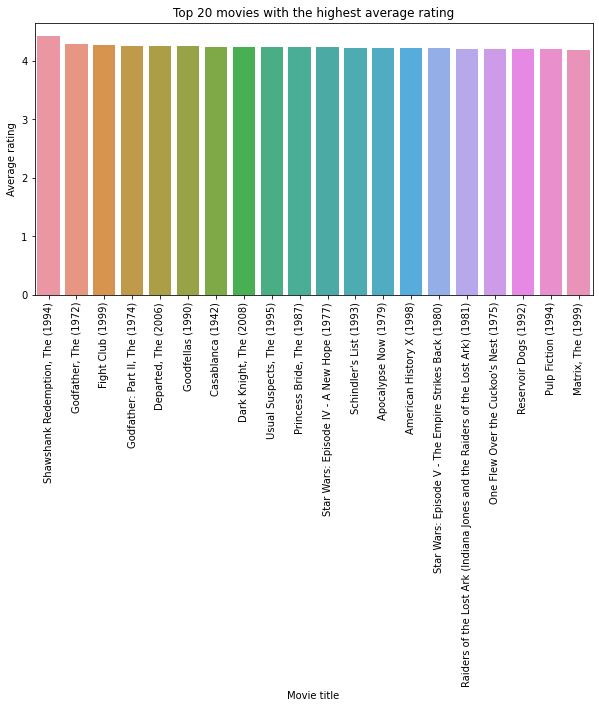

In [134]:
# plot top 20 of the average rating for each movie rated more than 100 times
top_movies = ratings.groupby('title').filter(lambda x: len(x) >= 100).groupby('title')['rating'].mean().sort_values(ascending=False).head(20)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_movies.index, y=top_movies.values)
plt.xlabel('Movie title')
plt.ylabel('Average rating')
plt.title('Top 20 movies with the highest average rating')
plt.xticks(rotation=90)
plt.show()


# Data Wrangling and Preprocessing

Before we can start building our movie recommender system, we need to perform some data wrangling and preprocessing on the MovieLens dataset. The dataset contains a large number of ratings and reviews for movies, and we need to extract the relevant features and organize the data in an optimised way that is suitable for training our model.

We will do this in the following steps:

1. Load the data
2. Extract the relevant features
3. Create two mappings: one for the movies and its index, and one for the users and their index (for the range of movies they have rated) as well as the ratings they have given.
4. Create a sparse matrix of the ratings
5. Split the data into training and test sets

In [23]:
# create a list of tuples: for every unique userId store a list of tuples (movieId, rating)
ratings_list = ratings.groupby('userId')['movieId', 'rating'].apply(lambda x: x.values.tolist()).tolist()
# convert to tuple to make it hashable
ratings_list = [tuple(map(tuple, x)) for x in ratings_list]
# print the first list
ratings_list[0]

<ipython-input-23-2b26467b3a04>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ratings_list = ratings.groupby('userId')['movieId', 'rating'].apply(lambda x: x.values.tolist()).tolist()


((1.0, 4.0),
 (3.0, 4.0),
 (6.0, 4.0),
 (47.0, 5.0),
 (50.0, 5.0),
 (70.0, 3.0),
 (101.0, 5.0),
 (110.0, 4.0),
 (151.0, 5.0),
 (157.0, 5.0),
 (163.0, 5.0),
 (216.0, 5.0),
 (223.0, 3.0),
 (231.0, 5.0),
 (235.0, 4.0),
 (260.0, 5.0),
 (296.0, 3.0),
 (316.0, 3.0),
 (333.0, 5.0),
 (349.0, 4.0),
 (356.0, 4.0),
 (362.0, 5.0),
 (367.0, 4.0),
 (423.0, 3.0),
 (441.0, 4.0),
 (457.0, 5.0),
 (480.0, 4.0),
 (500.0, 3.0),
 (527.0, 5.0),
 (543.0, 4.0),
 (552.0, 4.0),
 (553.0, 5.0),
 (590.0, 4.0),
 (592.0, 4.0),
 (593.0, 4.0),
 (596.0, 5.0),
 (608.0, 5.0),
 (648.0, 3.0),
 (661.0, 5.0),
 (673.0, 3.0),
 (733.0, 4.0),
 (736.0, 3.0),
 (780.0, 3.0),
 (804.0, 4.0),
 (919.0, 5.0),
 (923.0, 5.0),
 (940.0, 5.0),
 (943.0, 4.0),
 (954.0, 5.0),
 (1009.0, 3.0),
 (1023.0, 5.0),
 (1024.0, 5.0),
 (1025.0, 5.0),
 (1029.0, 5.0),
 (1030.0, 3.0),
 (1031.0, 5.0),
 (1032.0, 5.0),
 (1042.0, 4.0),
 (1049.0, 5.0),
 (1060.0, 4.0),
 (1073.0, 5.0),
 (1080.0, 5.0),
 (1089.0, 5.0),
 (1090.0, 4.0),
 (1092.0, 5.0),
 (1097.0, 5.0),
 (

In [24]:
# create a dictionary of ratings: for every unique userId store a dictionary {movieId: rating}
ratings_dict = ratings.groupby('userId')['movieId', 'rating'].apply(lambda x: x.set_index('movieId')['rating'].to_dict()).to_dict()
# print the first dictionary
ratings_dict[1]

<ipython-input-24-bedae8e70ad9>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ratings_dict = ratings.groupby('userId')['movieId', 'rating'].apply(lambda x: x.set_index('movieId')['rating'].to_dict()).to_dict()


{1: 4.0,
 3: 4.0,
 6: 4.0,
 47: 5.0,
 50: 5.0,
 70: 3.0,
 101: 5.0,
 110: 4.0,
 151: 5.0,
 157: 5.0,
 163: 5.0,
 216: 5.0,
 223: 3.0,
 231: 5.0,
 235: 4.0,
 260: 5.0,
 296: 3.0,
 316: 3.0,
 333: 5.0,
 349: 4.0,
 356: 4.0,
 362: 5.0,
 367: 4.0,
 423: 3.0,
 441: 4.0,
 457: 5.0,
 480: 4.0,
 500: 3.0,
 527: 5.0,
 543: 4.0,
 552: 4.0,
 553: 5.0,
 590: 4.0,
 592: 4.0,
 593: 4.0,
 596: 5.0,
 608: 5.0,
 648: 3.0,
 661: 5.0,
 673: 3.0,
 733: 4.0,
 736: 3.0,
 780: 3.0,
 804: 4.0,
 919: 5.0,
 923: 5.0,
 940: 5.0,
 943: 4.0,
 954: 5.0,
 1009: 3.0,
 1023: 5.0,
 1024: 5.0,
 1025: 5.0,
 1029: 5.0,
 1030: 3.0,
 1031: 5.0,
 1032: 5.0,
 1042: 4.0,
 1049: 5.0,
 1060: 4.0,
 1073: 5.0,
 1080: 5.0,
 1089: 5.0,
 1090: 4.0,
 1092: 5.0,
 1097: 5.0,
 1127: 4.0,
 1136: 5.0,
 1196: 5.0,
 1197: 5.0,
 1198: 5.0,
 1206: 5.0,
 1208: 4.0,
 1210: 5.0,
 1213: 5.0,
 1214: 4.0,
 1219: 2.0,
 1220: 5.0,
 1222: 5.0,
 1224: 5.0,
 1226: 5.0,
 1240: 5.0,
 1256: 5.0,
 1258: 3.0,
 1265: 4.0,
 1270: 5.0,
 1275: 5.0,
 1278: 5.0,
 1

In [25]:
# create a list of tuples: for every movie_id what is the list of users that rated it (userId, rating)
movies_list = ratings.groupby('movieId')['userId', 'rating'].apply(lambda x: x.values.tolist()).tolist()
# convert to tuple to make it hashable
movies_list = [tuple(map(tuple, x)) for x in movies_list]
# print the first list
movies_list[0]

<ipython-input-25-f2df092249e3>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  movies_list = ratings.groupby('movieId')['userId', 'rating'].apply(lambda x: x.values.tolist()).tolist()


((1.0, 4.0),
 (5.0, 4.0),
 (7.0, 4.5),
 (15.0, 2.5),
 (17.0, 4.5),
 (18.0, 3.5),
 (19.0, 4.0),
 (21.0, 3.5),
 (27.0, 3.0),
 (31.0, 5.0),
 (32.0, 3.0),
 (33.0, 3.0),
 (40.0, 5.0),
 (43.0, 5.0),
 (44.0, 3.0),
 (45.0, 4.0),
 (46.0, 5.0),
 (50.0, 3.0),
 (54.0, 3.0),
 (57.0, 5.0),
 (63.0, 5.0),
 (64.0, 4.0),
 (66.0, 4.0),
 (68.0, 2.5),
 (71.0, 5.0),
 (73.0, 4.5),
 (76.0, 0.5),
 (78.0, 4.0),
 (82.0, 2.5),
 (86.0, 4.0),
 (89.0, 3.0),
 (90.0, 3.0),
 (91.0, 4.0),
 (93.0, 3.0),
 (96.0, 5.0),
 (98.0, 4.5),
 (103.0, 4.0),
 (107.0, 4.0),
 (112.0, 3.0),
 (119.0, 3.5),
 (121.0, 4.0),
 (124.0, 4.0),
 (130.0, 3.0),
 (132.0, 2.0),
 (134.0, 3.0),
 (135.0, 4.0),
 (137.0, 4.0),
 (140.0, 3.0),
 (141.0, 4.0),
 (144.0, 3.5),
 (145.0, 5.0),
 (151.0, 5.0),
 (153.0, 2.0),
 (155.0, 3.0),
 (156.0, 4.0),
 (159.0, 4.5),
 (160.0, 4.0),
 (161.0, 4.0),
 (166.0, 5.0),
 (167.0, 3.5),
 (169.0, 4.5),
 (171.0, 5.0),
 (177.0, 5.0),
 (178.0, 4.0),
 (179.0, 4.0),
 (182.0, 4.0),
 (185.0, 4.0),
 (186.0, 4.0),
 (191.0, 4.0),
 (19

In [26]:
# create a dictionary of ratings: for every movie_id what is the dictionary of users that rated it {userId: rating}
movies_dict = ratings.groupby('movieId')['userId', 'rating'].apply(lambda x: x.set_index('userId')['rating'].to_dict()).to_dict()
# print the first dictionary
movies_dict[1]

<ipython-input-26-1e043b2c836e>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  movies_dict = ratings.groupby('movieId')['userId', 'rating'].apply(lambda x: x.set_index('userId')['rating'].to_dict()).to_dict()


{1: 4.0,
 5: 4.0,
 7: 4.5,
 15: 2.5,
 17: 4.5,
 18: 3.5,
 19: 4.0,
 21: 3.5,
 27: 3.0,
 31: 5.0,
 32: 3.0,
 33: 3.0,
 40: 5.0,
 43: 5.0,
 44: 3.0,
 45: 4.0,
 46: 5.0,
 50: 3.0,
 54: 3.0,
 57: 5.0,
 63: 5.0,
 64: 4.0,
 66: 4.0,
 68: 2.5,
 71: 5.0,
 73: 4.5,
 76: 0.5,
 78: 4.0,
 82: 2.5,
 86: 4.0,
 89: 3.0,
 90: 3.0,
 91: 4.0,
 93: 3.0,
 96: 5.0,
 98: 4.5,
 103: 4.0,
 107: 4.0,
 112: 3.0,
 119: 3.5,
 121: 4.0,
 124: 4.0,
 130: 3.0,
 132: 2.0,
 134: 3.0,
 135: 4.0,
 137: 4.0,
 140: 3.0,
 141: 4.0,
 144: 3.5,
 145: 5.0,
 151: 5.0,
 153: 2.0,
 155: 3.0,
 156: 4.0,
 159: 4.5,
 160: 4.0,
 161: 4.0,
 166: 5.0,
 167: 3.5,
 169: 4.5,
 171: 5.0,
 177: 5.0,
 178: 4.0,
 179: 4.0,
 182: 4.0,
 185: 4.0,
 186: 4.0,
 191: 4.0,
 193: 2.0,
 200: 3.5,
 201: 5.0,
 202: 4.0,
 206: 5.0,
 213: 3.5,
 214: 3.0,
 216: 3.0,
 217: 4.0,
 219: 3.5,
 220: 5.0,
 223: 3.5,
 226: 3.5,
 229: 5.0,
 232: 3.5,
 233: 3.0,
 234: 5.0,
 239: 4.0,
 240: 5.0,
 247: 5.0,
 249: 4.0,
 252: 4.5,
 254: 4.5,
 263: 4.0,
 264: 4.0,
 266:

In [27]:
# create a dictionary that maps the movieId to the movie title
movieId_to_title = movies.set_index('movieId')['title'].to_dict()
# print the first 10 items
list(movieId_to_title.items())[:10]

[(1, 'Toy Story (1995)'),
 (2, 'Jumanji (1995)'),
 (3, 'Grumpier Old Men (1995)'),
 (4, 'Waiting to Exhale (1995)'),
 (5, 'Father of the Bride Part II (1995)'),
 (6, 'Heat (1995)'),
 (7, 'Sabrina (1995)'),
 (8, 'Tom and Huck (1995)'),
 (9, 'Sudden Death (1995)'),
 (10, 'GoldenEye (1995)')]

In [28]:
# indexing: create a list that maps the movieId to a new index (0, 1, 2, ...)
movieId_to_index = {movieId: i for i, movieId in enumerate(movies['movieId'].unique())}

# indexing: create a list that maps the new index to the movieId (0 -> movieId, 1 -> movieId, 2 -> movieId, ...)
index_to_movieId = {i: movieId for movieId, i in movieId_to_index.items()}

In [29]:
movieId_to_index

{1: 0,
 2: 1,
 3: 2,
 4: 3,
 5: 4,
 6: 5,
 7: 6,
 8: 7,
 9: 8,
 10: 9,
 11: 10,
 12: 11,
 13: 12,
 14: 13,
 15: 14,
 16: 15,
 17: 16,
 18: 17,
 19: 18,
 20: 19,
 21: 20,
 22: 21,
 23: 22,
 24: 23,
 25: 24,
 26: 25,
 27: 26,
 28: 27,
 29: 28,
 30: 29,
 31: 30,
 32: 31,
 34: 32,
 36: 33,
 38: 34,
 39: 35,
 40: 36,
 41: 37,
 42: 38,
 43: 39,
 44: 40,
 45: 41,
 46: 42,
 47: 43,
 48: 44,
 49: 45,
 50: 46,
 52: 47,
 53: 48,
 54: 49,
 55: 50,
 57: 51,
 58: 52,
 60: 53,
 61: 54,
 62: 55,
 63: 56,
 64: 57,
 65: 58,
 66: 59,
 68: 60,
 69: 61,
 70: 62,
 71: 63,
 72: 64,
 73: 65,
 74: 66,
 75: 67,
 76: 68,
 77: 69,
 78: 70,
 79: 71,
 80: 72,
 81: 73,
 82: 74,
 83: 75,
 85: 76,
 86: 77,
 87: 78,
 88: 79,
 89: 80,
 92: 81,
 93: 82,
 94: 83,
 95: 84,
 96: 85,
 97: 86,
 99: 87,
 100: 88,
 101: 89,
 102: 90,
 103: 91,
 104: 92,
 105: 93,
 106: 94,
 107: 95,
 108: 96,
 110: 97,
 111: 98,
 112: 99,
 113: 100,
 116: 101,
 117: 102,
 118: 103,
 119: 104,
 121: 105,
 122: 106,
 123: 107,
 125: 108,
 126: 10

In [30]:
index_to_movieId

{0: 1,
 1: 2,
 2: 3,
 3: 4,
 4: 5,
 5: 6,
 6: 7,
 7: 8,
 8: 9,
 9: 10,
 10: 11,
 11: 12,
 12: 13,
 13: 14,
 14: 15,
 15: 16,
 16: 17,
 17: 18,
 18: 19,
 19: 20,
 20: 21,
 21: 22,
 22: 23,
 23: 24,
 24: 25,
 25: 26,
 26: 27,
 27: 28,
 28: 29,
 29: 30,
 30: 31,
 31: 32,
 32: 34,
 33: 36,
 34: 38,
 35: 39,
 36: 40,
 37: 41,
 38: 42,
 39: 43,
 40: 44,
 41: 45,
 42: 46,
 43: 47,
 44: 48,
 45: 49,
 46: 50,
 47: 52,
 48: 53,
 49: 54,
 50: 55,
 51: 57,
 52: 58,
 53: 60,
 54: 61,
 55: 62,
 56: 63,
 57: 64,
 58: 65,
 59: 66,
 60: 68,
 61: 69,
 62: 70,
 63: 71,
 64: 72,
 65: 73,
 66: 74,
 67: 75,
 68: 76,
 69: 77,
 70: 78,
 71: 79,
 72: 80,
 73: 81,
 74: 82,
 75: 83,
 76: 85,
 77: 86,
 78: 87,
 79: 88,
 80: 89,
 81: 92,
 82: 93,
 83: 94,
 84: 95,
 85: 96,
 86: 97,
 87: 99,
 88: 100,
 89: 101,
 90: 102,
 91: 103,
 92: 104,
 93: 105,
 94: 106,
 95: 107,
 96: 108,
 97: 110,
 98: 111,
 99: 112,
 100: 113,
 101: 116,
 102: 117,
 103: 118,
 104: 119,
 105: 121,
 106: 122,
 107: 123,
 108: 125,
 109: 12

In [31]:
# similary for the userId (0, 1, 2, ...)
userId_to_index = {userId: i for i, userId in enumerate(ratings['userId'].unique())}
index_to_userId = {i: userId for userId, i in userId_to_index.items()}

In [32]:
userId_to_index

{1: 0,
 5: 1,
 7: 2,
 15: 3,
 17: 4,
 18: 5,
 19: 6,
 21: 7,
 27: 8,
 31: 9,
 32: 10,
 33: 11,
 40: 12,
 43: 13,
 44: 14,
 45: 15,
 46: 16,
 50: 17,
 54: 18,
 57: 19,
 63: 20,
 64: 21,
 66: 22,
 68: 23,
 71: 24,
 73: 25,
 76: 26,
 78: 27,
 82: 28,
 86: 29,
 89: 30,
 90: 31,
 91: 32,
 93: 33,
 96: 34,
 98: 35,
 103: 36,
 107: 37,
 112: 38,
 119: 39,
 121: 40,
 124: 41,
 130: 42,
 132: 43,
 134: 44,
 135: 45,
 137: 46,
 140: 47,
 141: 48,
 144: 49,
 145: 50,
 151: 51,
 153: 52,
 155: 53,
 156: 54,
 159: 55,
 160: 56,
 161: 57,
 166: 58,
 167: 59,
 169: 60,
 171: 61,
 177: 62,
 178: 63,
 179: 64,
 182: 65,
 185: 66,
 186: 67,
 191: 68,
 193: 69,
 200: 70,
 201: 71,
 202: 72,
 206: 73,
 213: 74,
 214: 75,
 216: 76,
 217: 77,
 219: 78,
 220: 79,
 223: 80,
 226: 81,
 229: 82,
 232: 83,
 233: 84,
 234: 85,
 239: 86,
 240: 87,
 247: 88,
 249: 89,
 252: 90,
 254: 91,
 263: 92,
 264: 93,
 266: 94,
 269: 95,
 270: 96,
 273: 97,
 274: 98,
 275: 99,
 276: 100,
 277: 101,
 279: 102,
 280: 103,
 282:

In [34]:
index_to_userId

{0: 1,
 1: 5,
 2: 7,
 3: 15,
 4: 17,
 5: 18,
 6: 19,
 7: 21,
 8: 27,
 9: 31,
 10: 32,
 11: 33,
 12: 40,
 13: 43,
 14: 44,
 15: 45,
 16: 46,
 17: 50,
 18: 54,
 19: 57,
 20: 63,
 21: 64,
 22: 66,
 23: 68,
 24: 71,
 25: 73,
 26: 76,
 27: 78,
 28: 82,
 29: 86,
 30: 89,
 31: 90,
 32: 91,
 33: 93,
 34: 96,
 35: 98,
 36: 103,
 37: 107,
 38: 112,
 39: 119,
 40: 121,
 41: 124,
 42: 130,
 43: 132,
 44: 134,
 45: 135,
 46: 137,
 47: 140,
 48: 141,
 49: 144,
 50: 145,
 51: 151,
 52: 153,
 53: 155,
 54: 156,
 55: 159,
 56: 160,
 57: 161,
 58: 166,
 59: 167,
 60: 169,
 61: 171,
 62: 177,
 63: 178,
 64: 179,
 65: 182,
 66: 185,
 67: 186,
 68: 191,
 69: 193,
 70: 200,
 71: 201,
 72: 202,
 73: 206,
 74: 213,
 75: 214,
 76: 216,
 77: 217,
 78: 219,
 79: 220,
 80: 223,
 81: 226,
 82: 229,
 83: 232,
 84: 233,
 85: 234,
 86: 239,
 87: 240,
 88: 247,
 89: 249,
 90: 252,
 91: 254,
 92: 263,
 93: 264,
 94: 266,
 95: 269,
 96: 270,
 97: 273,
 98: 274,
 99: 275,
 100: 276,
 101: 277,
 102: 279,
 103: 280,
 104:

In [42]:
# create a list of tuples: for every unique userId store a list of tuples (movieId, rating)
user_ratings_list = ratings.groupby('userId')['movieId', 'rating'].apply(lambda x: x.values.tolist()).tolist()
# convert to tuple to make it hashable
user_ratings_list = [tuple(map(tuple, x)) for x in user_ratings_list]

# create a dictionary of ratings: for every unique userId store a dictionary {movieId: rating}
user_ratings_dict = ratings.groupby('userId')['movieId', 'rating'].apply(lambda x: x.set_index('movieId')['rating'].to_dict()).to_dict()

# create a dictionary of user index and a list of movies they watched in a range
user_indexer = {}
user_range_index = []
movie_rating_list = []
start = 0
for user_id, user_ratings in enumerate(user_ratings_list):
    user_indexer[user_id] = []
    for movie_id, rating in user_ratings:
        movie_index = movieId_to_index[movie_id]
        user_indexer[user_id].append((movie_index, rating))
        movie_rating_tuple = (movie_index, rating)
        movie_rating_list.append(movie_rating_tuple)
    user_range_index.append((start, start + len(user_ratings)))
    start += len(user_ratings)

# create a list of users
users = list(range(len(user_ratings_list)))

# create a dictionary of movie index and a list of users who watched it
movie_indexer = {}
for movie_id, movie_ratings in movies_dict.items():
    movie_index = movieId_to_index[movie_id]
    movie_indexer[movie_index] = []
    for user_id, rating in movie_ratings.items():
        user_index = userId_to_index[user_id]
        movie_indexer[movie_index].append((user_index, rating))



<ipython-input-42-f4e9e48bd3b8>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  user_ratings_list = ratings.groupby('userId')['movieId', 'rating'].apply(lambda x: x.values.tolist()).tolist()
<ipython-input-42-f4e9e48bd3b8>:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  user_ratings_dict = ratings.groupby('userId')['movieId', 'rating'].apply(lambda x: x.set_index('movieId')['rating'].to_dict()).to_dict()


In [52]:
len(movie_indexer[0])

215

In [50]:
len(user_ratings_list[0])

232

In [48]:
user_range_index

[(0, 232),
 (232, 261),
 (261, 300),
 (300, 516),
 (516, 560),
 (560, 874),
 (874, 1026),
 (1026, 1073),
 (1073, 1119),
 (1119, 1259),
 (1259, 1323),
 (1323, 1355),
 (1355, 1386),
 (1386, 1434),
 (1434, 1569),
 (1569, 1667),
 (1667, 1772),
 (1772, 2274),
 (2274, 2977),
 (2977, 3219),
 (3219, 3662),
 (3662, 3781),
 (3781, 3902),
 (3902, 4012),
 (4012, 4038),
 (4038, 4059),
 (4059, 4194),
 (4194, 4764),
 (4764, 4845),
 (4845, 4879),
 (4879, 4929),
 (4929, 5031),
 (5031, 5187),
 (5187, 5273),
 (5273, 5296),
 (5296, 5356),
 (5356, 5377),
 (5377, 5455),
 (5455, 5555),
 (5555, 5658),
 (5658, 5875),
 (5875, 6315),
 (6315, 6429),
 (6429, 6477),
 (6477, 6876),
 (6876, 6918),
 (6918, 7058),
 (7058, 7091),
 (7091, 7112),
 (7112, 7422),
 (7422, 7781),
 (7781, 7911),
 (7911, 7931),
 (7931, 7964),
 (7964, 7989),
 (7989, 8035),
 (8035, 8511),
 (8511, 8623),
 (8623, 8730),
 (8730, 8752),
 (8752, 8791),
 (8791, 9157),
 (9157, 9428),
 (9428, 9945),
 (9945, 9979),
 (9979, 10324),
 (10324, 10360),
 (10360

In [53]:
users

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [60]:
movie_rating_list

[(0, 4.0),
 (2, 4.0),
 (5, 4.0),
 (43, 5.0),
 (46, 5.0),
 (62, 3.0),
 (89, 5.0),
 (97, 4.0),
 (124, 5.0),
 (130, 5.0),
 (136, 5.0),
 (184, 5.0),
 (190, 3.0),
 (197, 5.0),
 (201, 4.0),
 (224, 5.0),
 (257, 3.0),
 (275, 3.0),
 (291, 5.0),
 (307, 4.0),
 (314, 4.0),
 (320, 5.0),
 (325, 4.0),
 (367, 3.0),
 (384, 4.0),
 (398, 5.0),
 (418, 4.0),
 (436, 3.0),
 (461, 5.0),
 (476, 4.0),
 (484, 4.0),
 (485, 5.0),
 (508, 4.0),
 (509, 4.0),
 (510, 4.0),
 (513, 5.0),
 (520, 5.0),
 (546, 3.0),
 (551, 5.0),
 (559, 3.0),
 (592, 4.0),
 (594, 3.0),
 (615, 3.0),
 (632, 4.0),
 (701, 5.0),
 (705, 5.0),
 (720, 5.0),
 (723, 4.0),
 (734, 5.0),
 (767, 3.0),
 (781, 5.0),
 (782, 5.0),
 (783, 5.0),
 (786, 5.0),
 (787, 3.0),
 (788, 5.0),
 (789, 5.0),
 (797, 4.0),
 (801, 5.0),
 (810, 4.0),
 (815, 5.0),
 (820, 5.0),
 (828, 5.0),
 (829, 4.0),
 (831, 5.0),
 (836, 5.0),
 (856, 4.0),
 (863, 5.0),
 (898, 5.0),
 (899, 5.0),
 (900, 5.0),
 (907, 5.0),
 (909, 4.0),
 (911, 5.0),
 (914, 5.0),
 (915, 4.0),
 (920, 2.0),
 (921, 5.0

# Alternating Least Squares

In [64]:
import numpy as np

# Define hyperparameters
alpha = 10  # Regularization parameter
lambda_ = 0.1  # Regularization parameter
num_iterations = 10  # Number of iterations

# Initialize user and item biases
num_users = len(ratings_dict)
num_items = len(movies_dict)
user_bias = np.zeros(num_users)
item_bias = np.zeros(num_items)

# Define functions for getting user and item ratings
def get_user_ratings(m, ratings_dict):
    """
    Returns a list of (item_id, rating) pairs for the given user m.

    :param m: int, the user ID
    :param ratings_dict: dict, a dictionary where the keys are user IDs and the values are dictionaries
                         with movie IDs as keys and ratings as values.
    :return: list of (item_id, rating) pairs for the given user
    """
    return ratings_dict[m].items()

def get_item_ratings(n, ratings_dict):
    """
    Returns a list of (user_id, rating) pairs for the given item n.

    :param n: int, the item ID
    :param ratings_dict: dict, a dictionary where the keys are user IDs and the values are dictionaries
                         with movie IDs as keys and ratings as values.
    :return: list of (user_id, rating) pairs for the given item
    """
    item_ratings = []
    for user_id, ratings in ratings_dict.items():
        if n in ratings:
            item_ratings.append((user_id, ratings[n]))
    return item_ratings

# Perform alternating least squares algorithm
for iteration in range(num_iterations):
    # Update user biases
    for m in range(num_users):
        numerator = 0
        denominator = alpha

        for n, r in get_user_ratings(m, ratings_dict):
            numerator += lambda_ * (r - item_bias[n])**2
            denominator += lambda_

        user_bias[m] = numerator / denominator

    # Update item biases
    for n in range(num_items):
        numerator = 0
        denominator = alpha

        for m, r in get_item_ratings(n, ratings_dict):
            numerator += lambda_ * (r - user_bias[m])**2
            denominator += lambda_

        item_bias[n] = numerator / denominator


KeyError: 0